<a href="https://colab.research.google.com/github/Keyi1101/SmartMask/blob/Keran/StressModel_train/Stress_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun  7 06:47:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    39W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf

def load_files(path = "/content/WESAD/"):
  l = []
  for dir in os.listdir(path):
    if(dir.startswith('S')):
      with open(os.path.join(path, dir, dir + ".pkl"), "rb") as f:
        tmp = pickle.load(f, encoding="bytes")
        l.append(tmp)
  return l

def load_wrist(data):
  subject = []
  BVP = []
  ACC = []
  TEMP = []
  EDA = []
  label = []
  for i in data:
    subject.append(i[b'subject'])
    BVP.append(i[b'signal'][b'wrist'][b'BVP'])
    ACC.append(i[b'signal'][b'wrist'][b'ACC'])
    TEMP.append(i[b'signal'][b'wrist'][b'TEMP'])
    EDA.append(i[b'signal'][b'wrist'][b'EDA'])
    label.append(i[b'label'])

  df = pd.DataFrame({
      "subject": subject,
      "BVP": BVP,
      "ACC": ACC,
      "TEMP": TEMP,
      "EDA": EDA,
      "label": label
  })
  return df

def create_dataset(dataframe, relax_factor=0.95, augmentation_factor=0.5):
  if augmentation_factor >= 1:
    raise Exception("Invalid aug factor! ", augmentation_factor)

  BVP = []
  ACC = []
  TEMP = []
  EDA = []
  label = []
  count = 0
  for i in dataframe.index:
    label_i = dataframe['label'][i]
    BVP_i = dataframe['BVP'][i]
    ACC_i = dataframe['ACC'][i]
    TEMP_i = dataframe['TEMP'][i]
    EDA_i = dataframe['EDA'][i]
    ##time_frame = len(dataframe['label'][i])/700
    ##size = int(time_frame/5)
    length = len(dataframe['label'][i]) 
    aug = 1 - augmentation_factor
    stride = int(3500 * aug)
    stride_B = int(320 * aug)
    stride_A = int(160 * aug)
    stride_T = int(20 * aug)
    stride_E = int(20 * aug)
    n = int((length - 3500)/stride + 1)
    #no.samples = int((length - window)/stride + 1)
    for j in range(n):
      #filter data with label 1, 2, 3 > 95%
      label_ij = label_i[j*stride:j*stride+3500]
      if((label_ij==1).mean() >= relax_factor):
        label.append(1)
        BVP.append(BVP_i[j*stride_B:j*stride_B+320])
        ACC.append(ACC_i[j*stride_A:j*stride_A+160])
        TEMP.append(TEMP_i[j*stride_T:j*stride_T+20])
        EDA.append(EDA_i[j*stride_E:j*stride_E+20])
        count += 1
      elif((label_ij==2).mean() >= relax_factor):
        label.append(2)
        BVP.append(BVP_i[j*stride_B:j*stride_B+320])
        ACC.append(ACC_i[j*stride_A:j*stride_A+160])
        TEMP.append(TEMP_i[j*stride_T:j*stride_T+20])
        EDA.append(EDA_i[j*stride_E:j*stride_E+20])
        count += 1
      elif((label_ij==3).mean() >= relax_factor):
        label.append(3)
        BVP.append(BVP_i[j*stride_B:j*stride_B+320])
        ACC.append(ACC_i[j*stride_A:j*stride_A+160])
        TEMP.append(TEMP_i[j*stride_T:j*stride_T+20])
        EDA.append(EDA_i[j*stride_E:j*stride_E+20])
        count += 1
  BVP = np.array(BVP)
  ACC = np.array(ACC)
  TEMP = np.array(TEMP)
  EDA = np.array(EDA)
  label = np.array(label)
  print("BVP: ", BVP.shape)
  print("ACC: ", ACC.shape)
  print("TEMP: ", TEMP.shape)
  print("EDA: ", EDA.shape)
  print("label: ", label.shape)
  print("no. of samples: ", count)

  sum = 0
  for i in dataframe.index:
    sum += len(dataframe['label'][i])

  print("no. of samples from raw data: ", int(sum/3500))
  print("Percentage of converted samples: ", count/int(sum/3500))

  return {
      'BVP': BVP,
      'ACC': ACC,
      'TEMP': TEMP,
      'EDA': EDA,
      'label': label,
      'sample': count
  }

def get_unbiased_data(dataset, FC=False, seed=None):
  #stress: 2 -> 1
  #baseline: 1 -> 0
  length = min((dataset['label']==1).sum(), (dataset['label']==2).sum())
  mask_b = dataset['label']==1
  mask_s = dataset['label']==2
  
  label = np.append(dataset['label'][mask_b][:length], dataset['label'][mask_s][:length], axis=0)
  label = np.asarray(label - 1, dtype=np.int32)
  BVP = np.append(dataset['BVP'][mask_b][:length], dataset['BVP'][mask_s][:length], axis=0).squeeze()
  ACC = np.append(dataset['ACC'][mask_b][:length], dataset['ACC'][mask_s][:length], axis=0)
  TEMP = np.append(dataset['TEMP'][mask_b][:length], dataset['TEMP'][mask_s][:length], axis=0).squeeze()
  EDA = np.append(dataset['EDA'][mask_b][:length], dataset['EDA'][mask_s][:length], axis=0).squeeze()

  BVP, ACC, TEMP, EDA, label = shuffle(BVP, ACC, TEMP, EDA, label, random_state=seed)
  print("Total number of unbiased training samples: ", len(label))
  if FC:
    X = {
        'BVP_in': BVP,
        'ACCx_in': ACC[:,:,0], 
        'ACCy_in': ACC[:,:,1],
        'ACCz_in': ACC[:,:,2],
        'TEMP_in': TEMP
    }
  else: 
    X = {
        'BVP_in': BVP[:,:,tf.newaxis],
        'ACCx_in': ACC[:,:,0][:,:,tf.newaxis], 
        'ACCy_in': ACC[:,:,1][:,:,tf.newaxis],
        'ACCz_in': ACC[:,:,2][:,:,tf.newaxis],
        'TEMP_in': TEMP
    }
  return X, label

In [ ]:
#Create model for FC_Stress_Binary_Classification
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.run_functions_eagerly(True)

#Input layers
BVP_input = keras.Input(shape=(320, ), name='BVP_in')
ACCx_input = keras.Input(shape=(160, ), name='ACCx_in')
ACCy_input = keras.Input(shape=(160, ), name='ACCy_in')
ACCz_input = keras.Input(shape=(160, ), name='ACCz_in')
TEMP_input = keras.Input(shape=(20, ), name='TEMP_in') 

#BVP feature layers
BVP_1 = layers.Dense(64, activation='relu', name='BVP_1')(BVP_input)
BVP_2 = layers.Dense(32, activation='relu', name='BVP_2')(BVP_1)

#ACC feature layers
ACCx_1 = layers.Dense(32, activation='relu', name='ACCx_1')(ACCx_input)
ACCy_1 = layers.Dense(32, activation='relu', name='ACCy_1')(ACCy_input)
ACCz_1 = layers.Dense(32, activation='relu', name='ACCz_1')(ACCz_input)

#Concatenate layer
x = layers.concatenate([BVP_2, ACCx_1, ACCy_1, ACCz_1, TEMP_input])
#Decision layers
Decision = layers.Dense(32, activation='relu')(x)
Decision = layers.Dense(16, activation='relu')(Decision)
Decision = layers.Dense(8, activation='relu')(Decision)
Decision = layers.Dense(1, activation='sigmoid', name='Prediction')(Decision)

FC_Stress_model = keras.Model(inputs=[BVP_input, ACCx_input, ACCy_input, ACCz_input, TEMP_input], outputs=[Decision])
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy()
FC_Stress_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

FC_Stress_model.summary()
keras.utils.plot_model(FC_Stress_model, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BVP_in (InputLayer)             [(None, 320)]        0                                            
__________________________________________________________________________________________________
BVP_1 (Dense)                   (None, 64)           20544       BVP_in[0][0]                     
__________________________________________________________________________________________________
ACCx_in (InputLayer)            [(None, 160)]        0                                            
__________________________________________________________________________________________________
ACCy_in (InputLayer)            [(None, 160)]        0                                            
____________________________________________________________________________________________

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BVP_in (InputLayer)             [(None, 320, 1)]     0                                            
__________________________________________________________________________________________________
BVP_1 (Conv1D)                  (None, 153, 2)       34          BVP_in[0][0]                     
__________________________________________________________________________________________________
max_pooling1d_55 (MaxPooling1D) (None, 75, 2)        0           BVP_1[0][0]                      
__________________________________________________________________________________________________
ACCx_in (InputLayer)            [(None, 160, 1)]     0                                            
____________________________________________________________________________________________

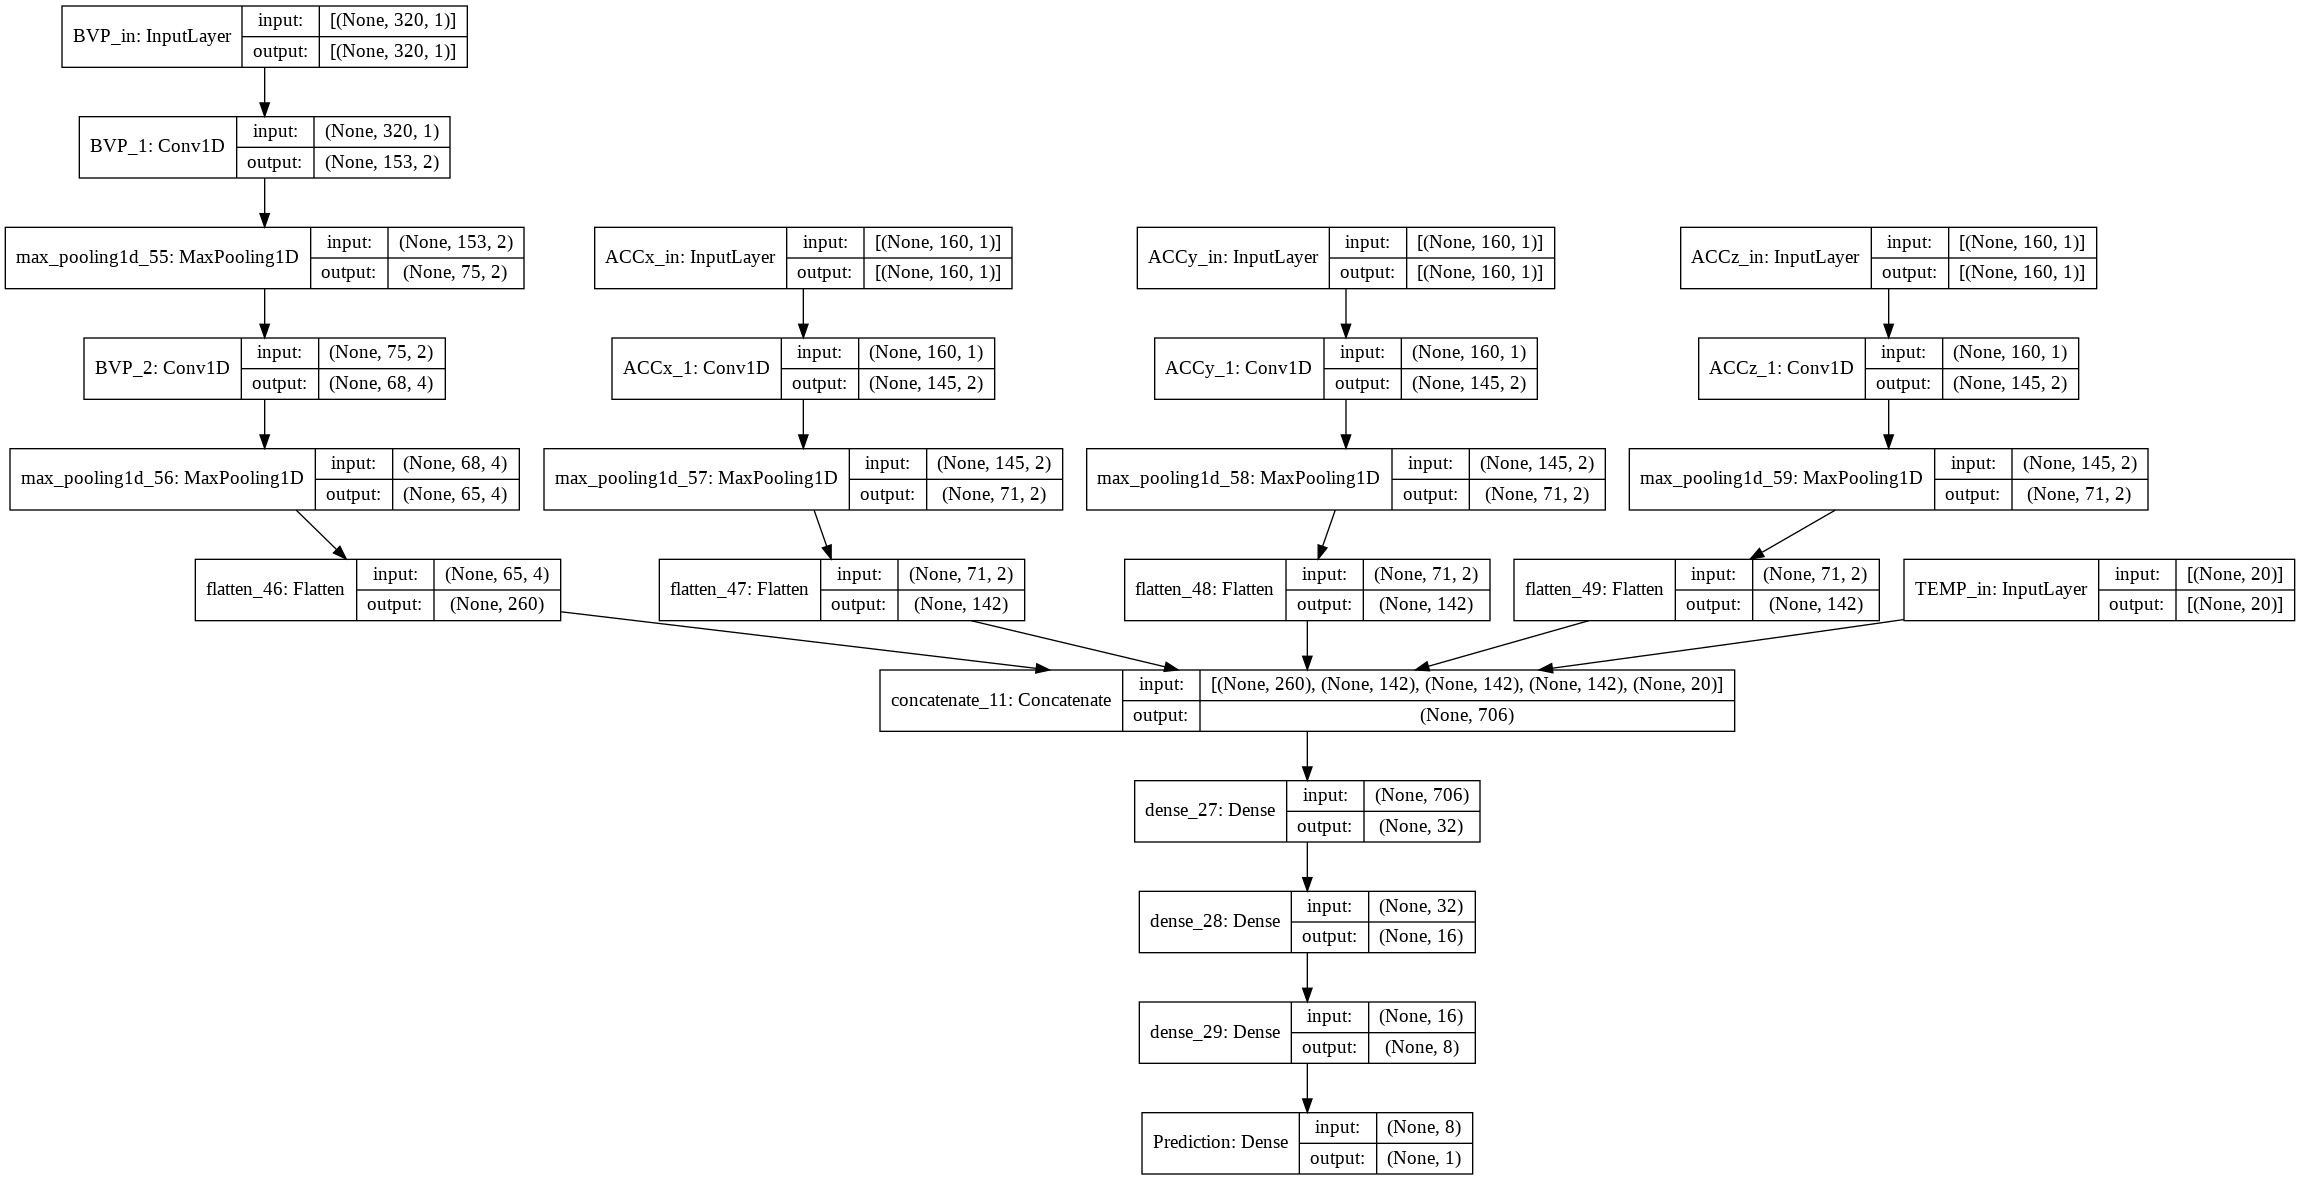

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)
# CNN_Stress_Binary_Classification
#Input layers
BVP_input = keras.Input(shape=(320, 1), name='BVP_in')
ACCx_input = keras.Input(shape=(160, 1), name='ACCx_in')
ACCy_input = keras.Input(shape=(160, 1), name='ACCy_in')
ACCz_input = keras.Input(shape=(160, 1), name='ACCz_in')
TEMP_input = keras.Input(shape=(20, ), name='TEMP_in') 
#TEMP_input = layers.Flatten()(TEMP_input)

#BVP feature layers
BVP_1 = layers.Conv1D(2, 16, strides=2, activation='relu', input_shape=(None, 320, 1), name='BVP_1')(BVP_input)
BVP_1 = layers.MaxPool1D(4, strides=2)(BVP_1)
BVP_2 = layers.Conv1D(4, 8, strides=1, activation='relu', name='BVP_2')(BVP_1)
BVP_2 = layers.MaxPool1D(4, strides=1)(BVP_2)
BVP_2 = layers.Flatten()(BVP_2)

#ACC feature layers
ACCx_1 = layers.Conv1D(2, 16, activation='relu', name='ACCx_1', input_shape=(None, 160, 1))(ACCx_input)
ACCx_1 = layers.MaxPool1D(4, strides=2)(ACCx_1)
ACCx_1 = layers.Flatten()(ACCx_1)

ACCy_1 = layers.Conv1D(2, 16, activation='relu', name='ACCy_1', input_shape=(None, 160, 1))(ACCy_input)
ACCy_1 = layers.MaxPool1D(4, strides=2)(ACCy_1)
ACCy_1 = layers.Flatten()(ACCy_1)

ACCz_1 = layers.Conv1D(2, 16, activation='relu', name='ACCz_1', input_shape=(None, 160, 1))(ACCz_input)
ACCz_1 = layers.MaxPool1D(4, strides=2)(ACCz_1)
ACCz_1 = layers.Flatten()(ACCz_1)

#Flatten Concatenate
x = layers.concatenate([BVP_2, ACCx_1, ACCy_1, ACCz_1, TEMP_input])

#Decision layers
Decision = layers.Dense(32, activation='relu')(x)
Decision = layers.Dense(16, activation='relu')(Decision)
Decision = layers.Dense(8, activation='relu')(Decision)
Decision = layers.Dense(1, activation='sigmoid', name='Prediction')(Decision)


CNN_Stress_model = keras.Model(inputs=[BVP_input, ACCx_input, ACCy_input, ACCz_input, TEMP_input], outputs=[Decision])
CNN_Stress_model.summary()
keras.utils.plot_model(CNN_Stress_model, show_shapes=True)

In [ ]:
#!wget https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download -O WESAD.zip
#!unzip -q ./WESAD.zip 

#raw_data = load_files()
wrist_data = load_wrist(raw_data)
dataset = create_dataset(wrist_data, relax_factor=0.95)
X_cnn, Y = get_unbiased_data(dataset, FC=False)


BVP:  (6590, 320, 1)
ACC:  (6590, 160, 3)
TEMP:  (6590, 20, 1)
EDA:  (6590, 20, 1)
label:  (6590,)
no. of samples:  6590
no. of samples from raw data:  17373
Percentage of converted samples:  0.3793242387612963


In [ ]:
#raw_data = load_files()
wrist_data = load_wrist(raw_data)
dataset = create_dataset(wrist_data, relax_factor=0.95, augmentation_factor=0.7)
X, Y = get_unbiased_data(dataset, FC=False)

BVP:  (21964, 320, 1)
ACC:  (21964, 160, 3)
TEMP:  (21964, 20, 1)
EDA:  (21964, 20, 1)
label:  (21964,)
no. of samples:  21964
no. of samples from raw data:  17373
Percentage of converted samples:  1.2642606343176193
Total number of unbiased training samples:  13202


In [ ]:
def scheduler(epoch, lr):
  if(epoch >0):
    if(epoch%20):
      return lr
    else:
      return lr*0.46
  else:
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy()
CNN_Stress_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


history_CNN_1 = CNN_Stress_model.fit(X, Y, batch_size=40, epochs=100, validation_split=0.3, callbacks=[lr_scheduler])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
  1/232 [..............................] - ETA: 18s - loss: 4.3392 - accuracy: 0.3750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


232/232 [==============================] - 11s 47ms/step - loss: 0.5275 - accuracy: 0.7486 - val_loss: 0.3710 - val_accuracy: 0.8096
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
232/232 [==============================] - 11s 47ms/step - loss: 0.3399 - accuracy: 0.8310 - val_loss: 0.3700 - val_accuracy: 0.8351
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
232/232 [==============================] - 11s 46ms/step - loss: 0.3063 - accuracy: 0.8516 - val_loss: 0.2986 - val_accuracy: 0.8670
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
232/232 [==============================] - 11s 46ms/step - loss: 0.2855 - accuracy: 0.8647 - val_loss: 0.2716 - val_accuracy: 0.8811
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
232/232 [==============================] - 11s 46ms/step - loss: 0.2710 - accura

In [ ]:
def scheduler(epoch, lr):
  if(epoch >0):
    if(epoch%20):
      return lr
    else:
      return lr*0.46
  else:
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy()
CNN_Stress_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


history_CNN = CNN_Stress_model.fit(X_cnn, Y, batch_size=40, epochs=100, validation_split=0.3, callbacks=[lr_scheduler])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
 1/70 [..............................] - ETA: 5s - loss: 18.3654 - accuracy: 0.4250

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 3s 47ms/step - loss: 2.3108 - accuracy: 0.6616 - val_loss: 0.8357 - val_accuracy: 0.6911
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
70/70 [==============================] - 3s 48ms/step - loss: 0.5901 - accuracy: 0.7514 - val_loss: 0.5309 - val_accuracy: 0.7854
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
70/70 [==============================] - 3s 45ms/step - loss: 0.4799 - accuracy: 0.7879 - val_loss: 0.5629 - val_accuracy: 0.7315
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
70/70 [==============================] - 3s 48ms/step - loss: 0.4643 - accuracy: 0.7955 - val_loss: 0.5061 - val_accuracy: 0.7753
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
70/70 [==============================] - 3s 45ms/step - loss: 0.3941 - accuracy: 0.8200 - va

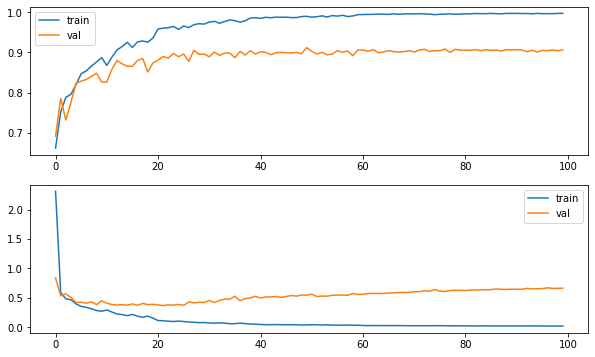

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].plot(history_CNN.history['accuracy'], label='train')
ax[0].plot(history_CNN.history['val_accuracy'], label='val')
ax[1].plot(history_CNN.history['loss'], label='train')
ax[1].plot(history_CNN.history['val_loss'], label='val')
ax[0].legend()
ax[1].legend()

In [ ]:
history = FC_Stress_model.fit(X, Y, batch_size=40, epochs=50, validation_split=0.3)

Epoch 1/100
 4/70 [>.............................] - ETA: 1s - loss: 2.9169 - accuracy: 0.4938

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 2s 24ms/step - loss: 0.8837 - accuracy: 0.7334 - val_loss: 0.5562 - val_accuracy: 0.7660
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 0.4295 - accuracy: 0.8120 - val_loss: 0.6239 - val_accuracy: 0.7340
Epoch 3/100
70/70 [==============================] - 2s 23ms/step - loss: 0.3548 - accuracy: 0.8387 - val_loss: 0.5198 - val_accuracy: 0.7879
Epoch 4/100
70/70 [==============================] - 2s 23ms/step - loss: 0.3146 - accuracy: 0.8568 - val_loss: 0.4861 - val_accuracy: 0.8081
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 0.3121 - accuracy: 0.8604 - val_loss: 0.4962 - val_accuracy: 0.8207
Epoch 6/100
70/70 [==============================] - 2s 23ms/step - loss: 0.2719 - accuracy: 0.8781 - val_loss: 0.6512 - val_accuracy: 0.7719
Epoch 7/100
70/70 [==============================] - 2s 23ms/step - loss: 0.2769 - accuracy: 0.8766 - val_loss: 0.5002 - val_accuracy: 0.8140
Epoch 8/100
70/70 